# Vulcões em Vênus

Nesse notebook iremos abordar uma solução para o problema [*Volcanoes on Venus* do Kaggle](https://www.kaggle.com/fmena14/volcanoesvenus). O dataset consiste em imagens de sonda do planeta Vênus e o problema consiste em predizer se uma determinada imagem contém pelo menos um vulcão ou não. 

#### Bibliotecas e ferramentas

In [32]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

#### Ler dados de treino e teste
Os dados já estão separados, em treino e teste, entre imagens e *labels* (se a respectiva imagem contém pelo menos um vulcão ou não). Observe que para os *labels* estamos usando apenas a primeira coluna do dataset, pois as demais não são importantes para o problema. Após a leitura os dados são normalizados usando o Scaler.

In [15]:
X_train = pd.read_csv("data/train_images.csv", header=None)
y_train = pd.read_csv("data/train_labels.csv")["Volcano?"]
X_test = pd.read_csv("data/test_images.csv", header=None)
y_test = pd.read_csv("data/test_labels.csv")["Volcano?"]

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Separar dados de validação
20% dos dados do conjunto de treino são separados para formar o conjunto de validação.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#### Análise de Componentes Principais
Para reduzir a dimensionalidade das imagens (110 x110), usaremos PCA. Usamos **2000** componentes porque os primeiros **2000** autovetores retém **~97%** da variância.

In [22]:
pca = PCA(n_components=2000)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

### Treinamento e validação com SVM
Primeiro utilizamos um método de otimização para encontrar os melhores hiperparâmetros, validando o modelo.

In [24]:
import dlib
def get_score(p_C, p_gamma):
    svm = SVC(gamma=p_gamma, kernel='rbf',C=p_C)
    svm.fit(X_train_pca, y_train)
    pred = svm.predict(X_val_pca)
    return accuracy_score(y_val, pred)
params, score = dlib.find_max_global(get_score, [0.2, 1e-10],[4.0, 1], 20)
print('C = {}, gamma = {}, score = {}'.format(params[0], params[1], score))

C = 4.0, gamma = 6.351203999200737e-05, score = 0.95


Agora usamos os dados transformados com os parâmetros validados para treinar e testar o modelo.

In [28]:
svm = SVC(kernel='rbf', C=4.0, gamma=6.35e-5, probability=True)
svm.fit(X_train_pca, y_train)

SVC(C=4.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=6.35e-05, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Testes
Resultados das predições no conjunto de testes.

In [34]:
pred = svm.predict(X_test_pca)
print(classification_report(y_test, pred, target_names=['não-vulcão', 'vulcão']))
print("Score: {}".format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

 não-vulcão       0.94      0.98      0.96      2300
     vulcão       0.89      0.66      0.76       434

avg / total       0.93      0.93      0.93      2734

Score: 0.9337966349670812


### Curva ROC e área abaixo da curva

In [30]:
probs = svm.predict_proba(X_test_pca)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
auc_score = auc(fpr,tpr)

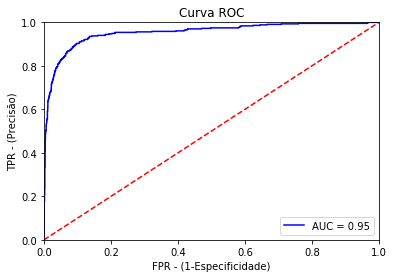

In [33]:
plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR - (Precisão)')
plt.xlabel('FPR - (1-Especificidade)')
plt.savefig('roc.png')
plt.show()